In [1]:
# zuko is installed in editable mode, so imports should work directly
# No sys.path manipulation needed

### LazyDistribution

PyTorch distributions themselves do not have trainable parameters, because they are not nn.Module subclasses.
A LazyDistribution in Zuko is an nn.Module whose forward method constructs a PyTorch distribution, allowing the parameters that generate the distribution to be learnable.

In [5]:
import torch
from zuko.lazy import LazyDistribution

class LazyNormal(LazyDistribution):
    def __init__(self, mu=0.0, sigma=1.0):
        super().__init__()
        self.mu = torch.nn.Parameter(torch.tensor(mu))
        self.log_sigma = torch.nn.Parameter(torch.log(torch.tensor(sigma)))

    def forward(self, c=None):
        return torch.distributions.Normal(self.mu, torch.exp(self.log_sigma))

In [6]:
# Data Generation Process
true_mu = 4.0
true_sigma = 1.5
y = torch.randn(5000) * true_sigma + true_mu

In [8]:
model = LazyNormal(mu=0.0, sigma=1.0)   # start far away
model().sample((1,3)), model().log_prob(0) 
#... All the pytorch function 

(tensor([[ 0.6907,  1.9062, -0.8005]]),
 tensor(-0.9189, grad_fn=<SubBackward0>))

In [10]:
model = LazyNormal(mu=0.0, sigma=1.0)   # start far away
opt = torch.optim.Adam(model.parameters(), lr=0.05)


for step in range(3000):
    dist = model()
    loss = -dist.log_prob(y).mean()  # negative log likelihood
    loss.backward()
    opt.step()
    opt.zero_grad()

print("Learned mu:", model.mu.item())
print("Learned sigma:", torch.exp(model.log_sigma).item())
print("Mean of Data:", y.mean().item())
print("Std of Data:", y.std().item())

Learned mu: 3.9944088459014893
Learned sigma: 1.5105427503585815
Mean of Data: 3.99440860748291
Std of Data: 1.5106935501098633


## Transformations


In [12]:
from zuko.transforms import BernsteinTransform
import zuko

transform = zuko.flows.MaskedAutoregressiveTransform(
    features=1,
    context=0,                                         # no context
    univariate=zuko.transforms.MonotonicRQSTransform, 
    shapes=([8], [8], [7]),                            # shapes of the spline parameters (8 bins)
    hidden_features=(64, 128, 256),                    # size of the hyper-network
)  # fmt: skip


M = 10
transform = zuko.flows.MaskedAutoregressiveTransform(
    features=1,
    context=0,
    univariate=BernsteinTransform,
    order=M, 
    shapes=([M+1],),
    hidden_features=(64, 128, 256),
)
f = transform()

In [13]:
u = f(torch.tensor([-5]))
print(u)
bernstein_transform = f.base 
bernstein_transform(torch.tensor([0]))

tensor([-4.7288], grad_fn=<WhereBackward0>)


tensor([-0.4199], grad_fn=<WhereBackward0>)

Bernstein coefficients: [-4.72878885269165, -4.287285327911377, -3.8457818031311035, -3.521026849746704, -2.105635643005371, -1.4458205699920654, -0.07557940483093262, 0.6129577159881592, 1.161731481552124, 1.7437937259674072, 2.135002851486206, 2.7854998111724854, 3.4359967708587646]


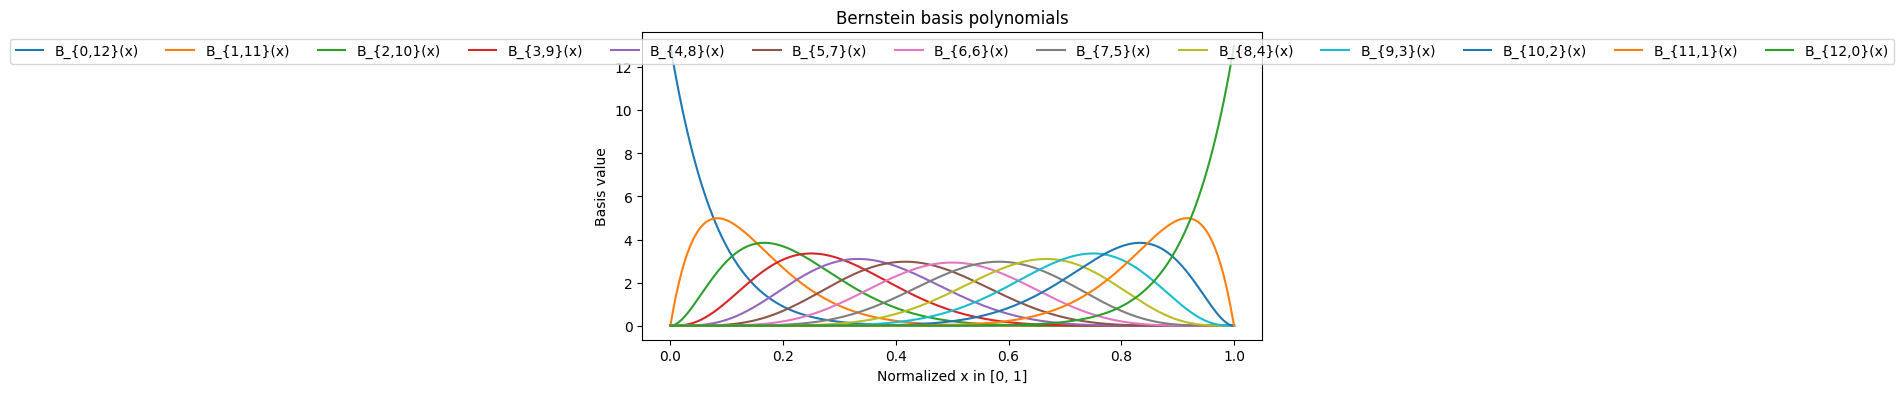

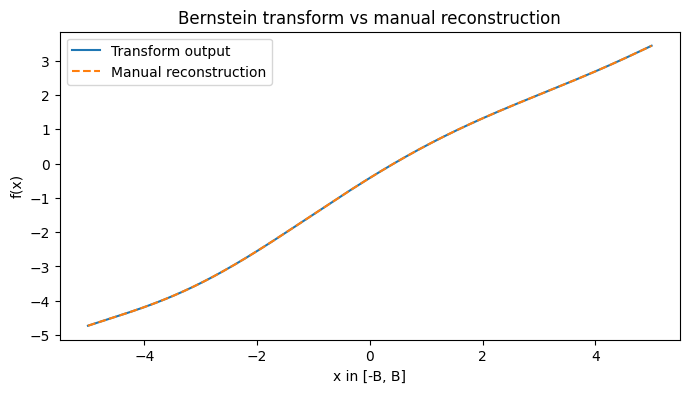

In [14]:
bernstein_transform = f.base  # DependentTransform wraps the Bernstein transform
bernstein_coeffs = bernstein_transform.theta.detach().squeeze()
print("Bernstein coefficients:", bernstein_coeffs.tolist())

order = bernstein_coeffs.shape[-1] - 1
bound = bernstein_transform.bound
x_unit = torch.linspace(bernstein_transform.eps, 1 - bernstein_transform.eps, 400)

# Bernstein basis polynomials on [0, 1]
basis_vals = bernstein_transform.basis.log_prob(x_unit.unsqueeze(-1)).exp().detach()
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
for i in range(order + 1):
    plt.plot(x_unit.numpy(), basis_vals[:, i].numpy(), label=fr"B_{{{i},{order - i}}}(x)")
plt.legend(loc="upper center", ncol=order + 1)
plt.xlabel("Normalized x in [0, 1]")
plt.ylabel("Basis value")
plt.title("Bernstein basis polynomials")
plt.show()

# Manually reconstruct f(x) from basis + coefficients
manual_u = torch.mean(basis_vals * bernstein_coeffs.view(1, -1), dim=-1)
x_full = x_unit * 2 * bound - bound
with torch.no_grad():
    u_transform = bernstein_transform(x_full)

plt.figure(figsize=(8, 4))
plt.plot(x_full.numpy(), u_transform.detach().numpy(), label="Transform output")
plt.plot(x_full.numpy(), manual_u.numpy(), "--", label="Manual reconstruction")
plt.xlabel("x in [-B, B]")
plt.ylabel("f(x)")
plt.title("Bernstein transform vs manual reconstruction")
plt.legend()
plt.show()


### Creating a flow


In [21]:
from zuko.flows import Flow
from zuko.lazy import UnconditionalDistribution
from zuko.distributions import DiagNormal

base = UnconditionalDistribution(DiagNormal, torch.zeros(1), torch.ones(1), buffer=True)
base().sample((1,))

b_flow = Flow(transform=transform, base=base)

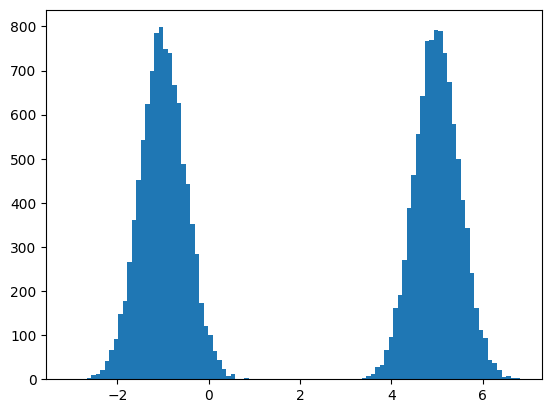

In [19]:
### Create some bimodal data data (-1,3)
y = torch.cat([torch.randn(10000) * 0.5 + 5, torch.randn(10000) * 0.5 - 1])
# histogram of y
plt.hist(y.numpy(), bins=100)
plt.show()

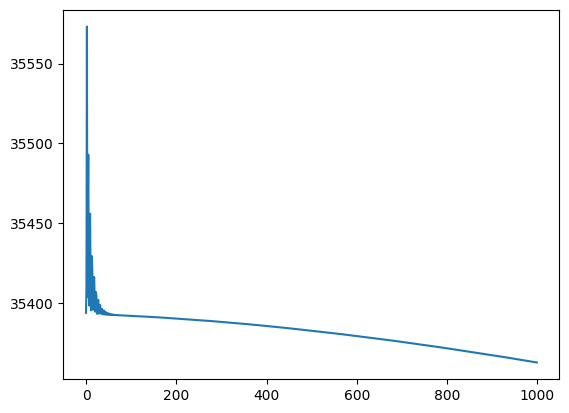

In [24]:
opt = torch.optim.Adam(b_flow.parameters(), lr=0.05)
history = []
for step in range(1000):
    dist = b_flow()
    loss = -dist.log_prob(y).mean()  # negative log likelihood
    loss.backward()
    opt.step()
    opt.zero_grad()
    history.append(loss.detach().numpy())
plt.plot(history)
plt.show()


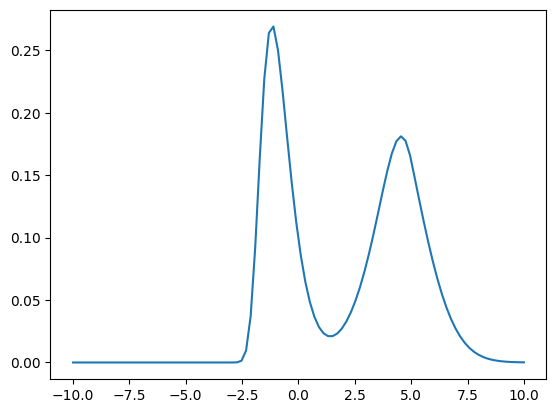

In [25]:
xs = torch.linspace(-10, 10, 100).unsqueeze(-1)
ys = torch.exp(b_flow().log_prob(xs))

sample = b_flow().sample((10000,))
# plt.hist(sample.numpy(), bins=100)
# plt.show()
plt.plot(xs.detach().numpy(), ys.detach().numpy())
#plt.hist(ys.detach().numpy(), bins=100)
plt.show()

## Fist Causal Flow

In [63]:
# DGP
# u1,u2,3 = normal(0,1)
# x1 = u1 + 1
# x2 = 1 * x1 + u2 
# x3 = 3 * x1 + u3 

from re import U


N = 1000
noise = torch.randn(N, 3)
X_train = torch.zeros(N, 3)
X_train[:,0] = noise[:,0] + 1
X_train[:,1] = noise[:,1] + 1 * X_train[:,0]
X_train[:,2] = noise[:,2] + 3 * X_train[:,0]

In [64]:
adjacency = torch.tril(torch.ones(3, 3))
adjacency[2,1] = 0
print(adjacency)

M = 10
transform = zuko.flows.MaskedAutoregressiveTransform(
    features=3,
    context=0,
    adjacency = adjacency,
    univariate=BernsteinTransform,
    order=M, 
    shapes=([M+1],),
    hidden_features=(64, 128, 256),
)
f = transform()

base = UnconditionalDistribution(DiagNormal, torch.zeros(3), torch.ones(3), buffer=True)
base().sample((1,))

from zuko.flows import Flow
b_flow = Flow(transform=transform, base=base)

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 0., 1.]])


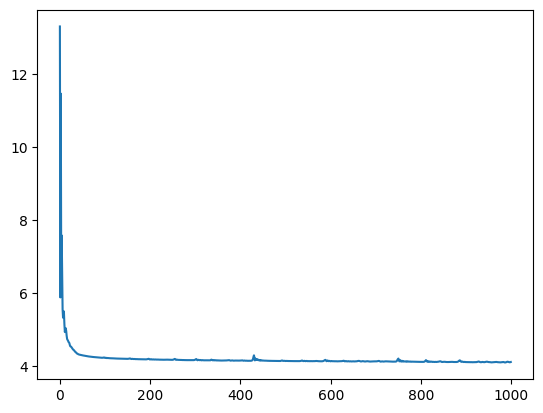

In [65]:
# Fit a flow
opt = torch.optim.Adam(b_flow.parameters(), lr=0.01)
history = []
for step in range(1000):
    dist = b_flow()
    loss = -dist.log_prob(X_train).mean()  # negative log likelihood
    loss.backward()
    opt.step()
    opt.zero_grad()
    history.append(loss.detach().numpy())
plt.plot(history)
plt.show()

### L1 (Pearl hierarchy)

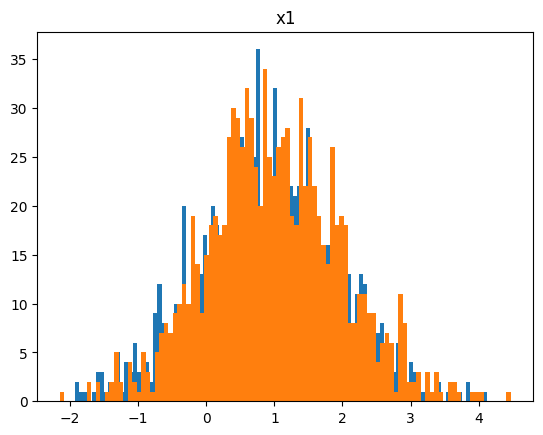

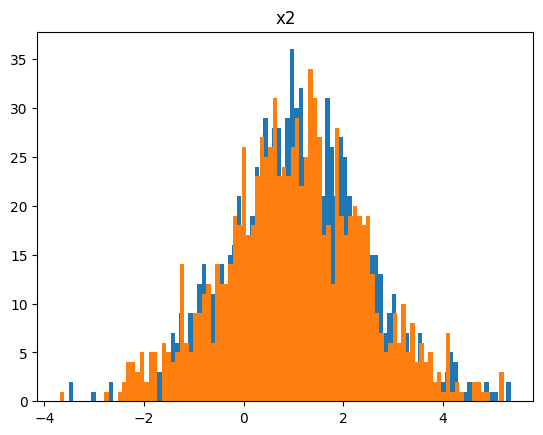

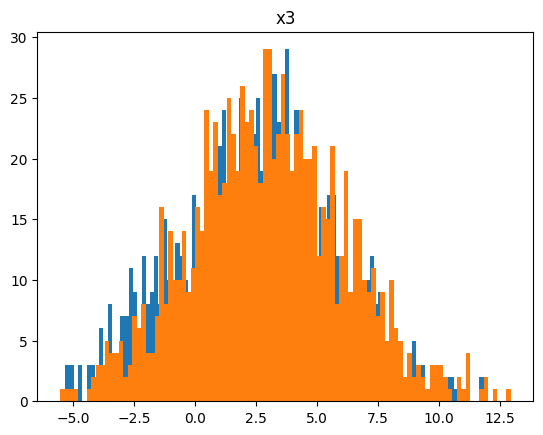

In [66]:
# Make a histogram of the training data draw 1000 samples from the flow and plot them in 3 plots
samples = b_flow().sample((1000,))
plt.hist(samples[:,0].numpy(), bins=100)
plt.hist(X_train[:,0].numpy(), bins=100)
plt.title("x1")
plt.show()
plt.hist(samples[:,1].numpy(), bins=100)
plt.hist(X_train[:,1].numpy(), bins=100)
plt.title("x2")
plt.show()
plt.hist(samples[:,2].numpy(), bins=100)
plt.hist(X_train[:,2].numpy(), bins=100)
plt.title("x3")
plt.show()

### L2 Pearl hierarchy (do(X1=2)
![Do](D1Do.png)


In [84]:
do_value = 2.0
do_index = 0
N = 1000
flow_dist = b_flow()
transform = flow_dist.transform
base_dist = flow_dist.base

u = base_dist.sample((N,)) # Line 2 in Algorithm 2
print("Latent samples shape:", u.shape)

x_obs = transform.inv(u) # Line 3 in Algorithm 2
print("Observational samples shape:", x_obs.shape)

# do(X1 = 2): clamp the first observed dimension while reusing the latent noise of the other nodes
x_template = x_obs.clone() #torch.zeros_like(x_obs)
x_template[:, do_index] = do_value # Line 4 in Algorithm 2
print("x_obs", x_obs[0:5,:])
print("x_template", x_template[0:5,:])

u_do = u.clone()
# map the do-value through the forward transform to find the latent associated with x1 = do_value
#u_do[:, :1] = transform(x_template)[:, :1]
u_do[:, do_index:do_index+1] = transform(x_template)[:, do_index:do_index+1] # Line 5 in Algorithm 2

# Check that only the u's in the do-index column have changed
print(u_do[0:4,:])
print(u[0:4,:])

x_do = transform.inv(u_do) # Line 6 in Algorithm 2
# Check only the do-index is set to the do-value and
#   prior colums (causal parents) are the same as the observational samples
#   causal downstream variables could differ
print("x_do", x_do[0:5,:])
print("x_obs", x_obs[0:5,:])

print("Interventional samples shape:", x_do.shape)
print("Mean of X1 under do Intervention:", x_do[:, 0].mean().item())
print("Mean of X2 under do Intervention:", x_do[:, 1].mean().item())
print("Mean of X3 under do Intervention:", x_do[:, 2].mean().item())


Latent samples shape: torch.Size([1000, 3])
Observational samples shape: torch.Size([1000, 3])
x_obs tensor([[ 0.7281, -0.3555,  1.5129],
        [ 2.2840,  1.2390,  7.0220],
        [-0.4247, -0.7795, -2.1859],
        [ 1.1746,  2.0441,  1.8784],
        [ 1.5734,  1.5023,  3.6010]], grad_fn=<SliceBackward0>)
x_template tensor([[ 2.0000, -0.3555,  1.5129],
        [ 2.0000,  1.2390,  7.0220],
        [ 2.0000, -0.7795, -2.1859],
        [ 2.0000,  2.0441,  1.8784],
        [ 2.0000,  1.5023,  3.6010]], grad_fn=<SliceBackward0>)
tensor([[ 1.0432, -0.9406, -0.6521],
        [ 1.0432, -0.8991,  0.3874],
        [ 1.0432, -0.6033, -0.2231],
        [ 1.0432,  0.9229, -1.6213]], grad_fn=<SliceBackward0>)
tensor([[-0.2624, -0.9406, -0.6521],
        [ 1.3136, -0.8991,  0.3874],
        [-1.4638, -0.6033, -0.2231],
        [ 0.2090,  0.9229, -1.6213]])
x_do tensor([[2.0000, 1.0326, 5.3193],
        [2.0000, 1.0696, 6.3852],
        [2.0000, 1.3392, 5.7592],
        [2.0000, 2.8659, 4.3297],

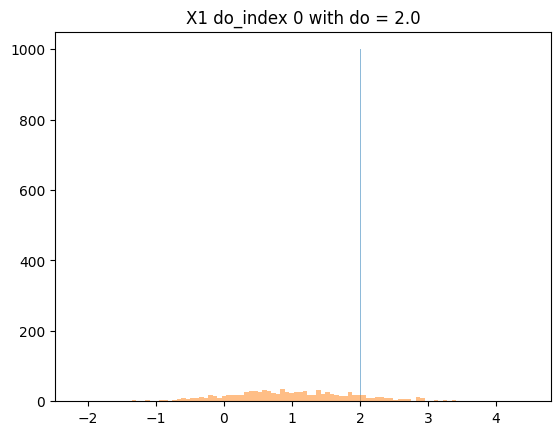

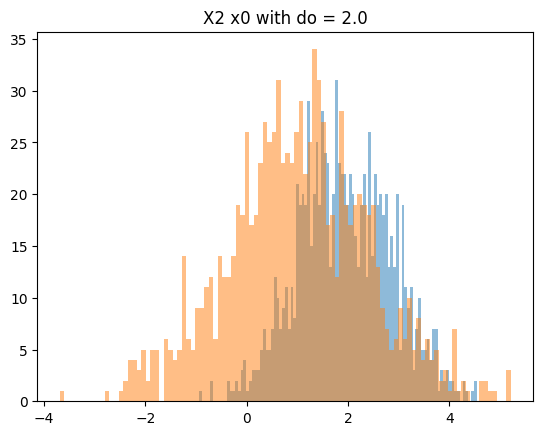

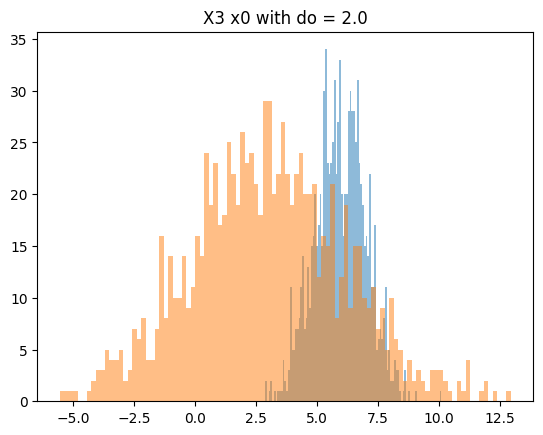

In [ ]:
# Make a histogram of the training data draw 1000 samples from the flow and plot them in 3 plots
plt.hist(x_do[:,0].detach().numpy(), bins=100, alpha=0.5)
plt.hist(X_train[:,0].detach().numpy(), bins=100, alpha=0.5)
plt.title(f"X1 do_index {do_index} with do = {do_value}")         
plt.show();
plt.hist(x_do[:,1].detach().numpy(), bins=100, alpha=0.5)
plt.hist(X_train[:,1].detach().numpy(), bins=100, alpha=0.5)
plt.title(f"X2 x{do_index} with do = {do_value}")
plt.show();
plt.hist(x_do[:,2].detach().numpy(), bins=100, alpha=0.5)
plt.hist(X_train[:,2].detach().numpy(), bins=100, alpha=0.5)
plt.title(f"X3 x{do_index} with do = {do_value}")
plt.show();

### L3 Pearl hierarchy 

![Do](CF.png)

In [73]:
x_factual = X_train #The observed data 
print("x_factual\n", x_factual[0:3,:])

x_factual
 tensor([[ 1.6226,  1.5348,  4.8357],
        [ 0.7370,  0.6074,  4.8887],
        [-0.1379, -1.9201, -1.7751]])


In [77]:
do_index = 1
# do_value = x_factual[:,0]
# All values of x1 should be the same as values of x1 in x_factual
do_value = torch.ones_like(x_factual[:,0]) * x_factual[0,1]
print("do_value\n", do_value[0:3])
N = 1000
flow_dist = b_flow()
transform = flow_dist.transform
base_dist = flow_dist.base

u = transform(x_factual) # Line 2 in Algorithm 3
# do(X1 = 2): clamp the first observed dimension while reusing the latent noise of the other nodes
x_template = x_factual.clone() 
x_template[:, do_index] = do_value # Line 3 in Algorithm 3

u_do = u.clone()
# map the do-value through the forward transform to find the latent associated with x1 = do_value
#u_do[:, :1] = transform(x_template)[:, :1]
u_do[:, do_index:do_index+1] = transform(x_template)[:, do_index:do_index+1] # Line 4 in Algorithm 3

x_cf = transform.inv(u_do) # Line 5 in Algorithm 3
# Check only the do-index is set to the do-value and
#   prior colums (causal parents) are the same as the observational samples
#   causal downstream variables could differ
print("x_factual", x_factual[0:5,:])
print("x_cf", x_cf[0:5,:])

print("Interventional samples shape:", x_do.shape)
print("Mean of X1 under do Intervention:", x_do[:, 0].mean().item())
print("Mean of X2 under do Intervention:", x_do[:, 1].mean().item())
print("Mean of X3 under do Intervention:", x_do[:, 2].mean().item())


do_value
 tensor([1.5348, 1.5348, 1.5348])
x_factual tensor([[ 1.6226,  1.5348,  4.8357],
        [ 0.7370,  0.6074,  4.8887],
        [-0.1379, -1.9201, -1.7751],
        [ 3.1227,  3.6623, 10.7896],
        [ 1.6697,  0.2797,  5.2111]])
x_cf tensor([[ 1.6226,  1.5348,  4.8357],
        [ 0.7370,  1.5348,  4.8887],
        [-0.1379,  1.5348, -1.7751],
        [ 3.1226,  1.5348, 10.7896],
        [ 1.6697,  1.5348,  5.2111]], grad_fn=<SliceBackward0>)
Interventional samples shape: torch.Size([1000, 3])
Mean of X1 under do Intervention: 0.9885461330413818
Mean of X2 under do Intervention: 1.1319706439971924
Mean of X3 under do Intervention: 2.0


In [91]:
# Visualize the learned transformation: x3 vs x1 for fixed x2 values
flow_dist = b_flow()
transform = flow_dist.transform

do_index = 0
do_vals = torch.linspace(-2.1, 5.0, 200)
x_template = torch.zeros(do_vals.shape[0], 3)
# Fixing dimensions 
x2 = X_train[1,1] * torch.ones(do_vals.shape[0])
x3 = X_train[1,2] * torch.ones(do_vals.shape[0])
X = torch.cat((do_vals.unsqueeze(-1), x2.unsqueeze(-1), x3.unsqueeze(-1)), dim=1)
X[0:3,:]

tensor([[-2.1000,  0.6074,  4.8887],
        [-2.0643,  0.6074,  4.8887],
        [-2.0286,  0.6074,  4.8887]])

/var/folders/bk/0vv7sh9n43n3dm4fth1qw93r0000gq/T/ipykernel_63106/1140104670.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


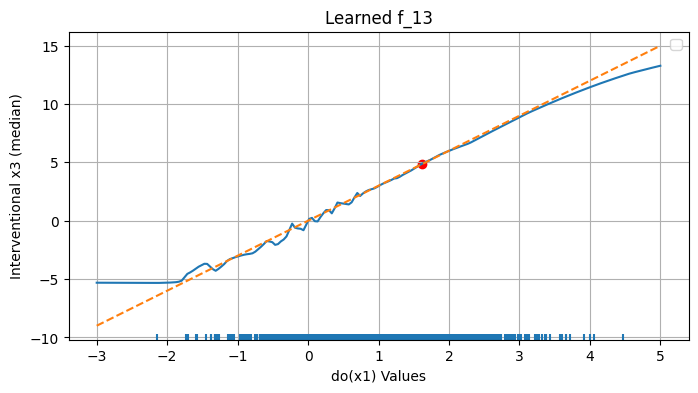

In [ ]:
# Visualize the learned transformation: x3 vs x1 for fixed x2 values
flow_dist = b_flow()
transform = flow_dist.transform

#do_index = 0
do_vals = torch.linspace(-3, 5.0, 200)
x_template = torch.zeros(do_vals.shape[0], 3)
# Fixing dimensions 
x2 = X_train[1,1] * torch.ones(do_vals.shape[0])
x3 = X_train[1,2] * torch.ones(do_vals.shape[0])
X = torch.cat((do_vals.unsqueeze(-1), x2.unsqueeze(-1), x3.unsqueeze(-1)), dim=1)

plt.figure(figsize=(8, 4))
with torch.no_grad():
    U = transform(X)
    U[:, 2] = 0.0 # Fixing u3 at 0 for median
    x_result = transform.inv(U)
    styles = ['--', '-.', '-']
    plt.plot(
        do_vals.detach().numpy(),
        x_result[:, 2].detach().numpy()
    )


# Add the training data for x1 on the plot (tick marks)
#plt.scatter(X_train[:,0].numpy(), X_train[:,2].numpy(), alpha=0.5, label="Training data")
plt.xlabel("do(x1) Values")
plt.ylabel("Interventional x3 (median)")
plt.title(f"Learned f_13")
plt.legend()
plt.grid(True)
#Add line with slope 3 and intercept 0
plt.plot(do_vals.detach().numpy(), 3 * do_vals.detach().numpy(), '--')

# Add point X_train[0,0] X_train[0,2]
plt.scatter(X_train[0,0], X_train[0,2], color='red')

plt.vlines(X_train[:,0], ymin=0, ymax=0.02, transform=plt.gca().get_xaxis_transform())
plt.show()


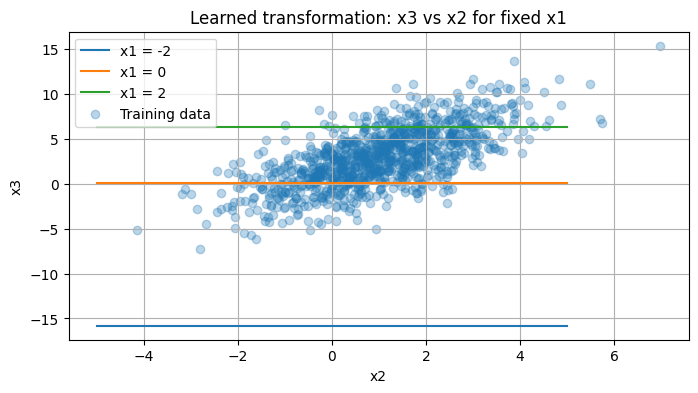

In [35]:
# Visualize the learned transformation: x3 vs x2 for fixed x1 values
flow_dist = b_flow()
transform = flow_dist.transform

x2_vals = torch.linspace(-5.0, 5.0, 200)
x1_settings = torch.tensor([-2.0, 0.0, 2.0])

plt.figure(figsize=(8, 4))
with torch.no_grad():
    for x1_value in x1_settings:
        x_template = torch.zeros(x2_vals.shape[0], 3)
        x_template[:, 0] = x1_value
        x_template[:, 1] = x2_vals

        u_template = transform(x_template)

        u = torch.zeros_like(x_template)
        u[:, 0] = u_template[:, 0]
        u[:, 1] = u_template[:, 1]
        u[:, 2] = 0.0

        x_result = transform.inv(u)
        plt.plot(
            x2_vals.detach().numpy(),
            x_result[:, 2].detach().numpy(),
            label=f"x1 = {x1_value.item():.0f}",
        )

plt.scatter(X_train[:,1].numpy(), X_train[:,2].numpy(), alpha=0.3, label="Training data")
plt.xlabel("x2")
plt.ylabel("x3")
plt.title("Learned transformation: x3 vs x2 for fixed x1")
plt.legend()
plt.grid(True)
plt.show()

